<a href="https://colab.research.google.com/github/juanpanu/StoryTellerAI/blob/main/storyTellerAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#read-PDF imports here
!pip install PyPDF2
import PyPDF2

#pre-processing imports here
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import string

     |████████████████████████████████| 81kB 7.5MB/s 
  Created wheel for PyPDF2: filename=PyPDF2-1.26.0-cp36-none-any.whl size=61086 sha256=885fd41733627bf0979bad091adb1ea48f3af222a32006674339744e94cd7d44
  Stored in directory: /root/.cache/pip/wheels/53/84/19/35bc977c8bf5f0c23a8a011aa958acd4da4bbd7a229315c1b7
Successfully built PyPDF2
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#file locations on drive
grimm_url = '/content/drive/My Drive/StoryTellerAI/FairytalesByTheBrothersGrimm.txt'
coraline_url = '/content/drive/My Drive/StoryTellerAI/Coraline.pdf'
alice_url = '/content/drive/My Drive/StoryTellerAI/AlicesAdvanturesInWonderland.txt'

In [ ]:
#load punctuation symbols
punct = string.punctuation

# **Pre-processing Coraline**

In [ ]:
#a function to pre process Coraline by Neil Gaiman

def preprocess_coraline(book):
  '''
  param book: url od a PDF book file
  '''
  output = ""
  data = open(book, 'rb')
  data = PyPDF2.PdfFileReader(book)
  npages = data.getNumPages()
  for i in range(npages):
    page_i = data.getPage(i).extractText()
    output += page_i
  output = output[1227:]
  output = output.lower()
  for word in output:
    for char in word:
        if char in punct:
            word = word.replace(char, "")
  remove_punct = "".join([word for word in output if word not in punct])
  # book_edit = re.sub('[\d]','',remove_punct)
  # processed = word_tokenize(book_edit)
  processed = word_tokenize(remove_punct)

  print('Coraline database includes {} tokens, and {} unique tokens after editing'.format(len(processed), len(set(processed)))) 
  return processed

coraline = preprocess_coraline(coraline_url) 

Coraline database includes 30835 tokens, and 3471 unique tokens after editing


## **Preprocessing Alice in Wonderland**

In [ ]:
#a function to pre process Alice's Advantures in Wonderland by Lewis Carroll

def load_alice(text_file, punct, not_a_word):
    '''
    param text_file: url to Project Gutenberg's text file for Alice's Advantures in Wonderland by Lewis Carroll
    param punct: a string of punctuation characters we'd like to filter
    param not_a_word: a list of words we'd like to filter
    '''
    book = open(text_file, 'r')
    book = book.read()
    book = book[715:145060]
    book_edit = re.sub('[+]', '', book)
    book_edit = re.sub(r'(CHAPTER \w+.\s)', '', book_edit)
    # book_edit = re.sub('[\d]','',book_edit)###
    words = word_tokenize(book_edit.lower())
    
    word_list = []
    
    # filtering punctuation and non-words
    for word in words:
        for char in word:
            if char in punct:
                word = word.replace(char, "")
        if word not in punct and word not in not_a_word:
            word_list.append(word)

    print('Alice database includes {} tokens, and {} unique tokens after editing'.format(len(word_list), len(set(word_list)))) 
    return word_list

alice = load_alice(alice_url, (punct.replace('-', "") + '’' + '‘'), ['s', '--', 'nt', 've', 'll', 'd'])

Alice database includes 26612 tokens, and 2596 unique tokens after editing


# **Preprocessing Grimm**


In [ ]:
def load_fairytales(text_file):
    '''
    param text_file: url to Project Gutenberg's text file for Fairytales by The Brothers Grimm
    '''
    book = open(text_file, encoding='cp1252')
    book = book.read()
    book = book[2376:519859]
    book_edit = re.sub('[(+*)]', '', book)
    # book_edit = re.sub('[\d]','',book_edit)####
    words = word_tokenize(book_edit.lower())

    # filtering punctuation inside tokens (example: didn't or wow!)
    for word in words:
        for char in word:
            if char in punct:
                word = word.replace(char, "")

    # filtering punctuation as alone standing tokens(example: \ or ,)
    words = [word for word in words if word not in punct]

    print('Fairytales database includes {} tokens, and {} unique tokens after editing'.format(len(words), len(set(words))))            
    return words

brothers_grimm = load_fairytales(grimm_url)

Fairytales database includes 106324 tokens, and 5335 unique tokens after editing


# **Combined database including all books**

In [ ]:
data = coraline + alice + brothers_grimm
data[:10]

['coraline',
 'discovered',
 'the',
 'door',
 'a',
 'little',
 'while',
 'after',
 'they',
 'moved']

# **Convert Data into Numeric Values**

In [ ]:
vocab = set(data)
vocab_size = len(data)

# word_to_index = {word: i for i, word in enumerate(vocab)}
# data = [word_to_index[word] for word in data]
# data[:10]

In [ ]:
vocab_size

163771

In [ ]:
# word_to_index['coraline']

# **Batching Data**

In [ ]:
batch_size = 5 #Looking first 5 words, network is going to guess the 6

train_data = [([data[i],
                data[i+1],
                data[i+2],
                data[i+3],
                data[i+4]],
                data[i+5])
             for i in range(vocab_size-batch_size)]

train_data[:10]

[(['coraline', 'discovered', 'the', 'door', 'a'], 'little'),
 (['discovered', 'the', 'door', 'a', 'little'], 'while'),
 (['the', 'door', 'a', 'little', 'while'], 'after'),
 (['door', 'a', 'little', 'while', 'after'], 'they'),
 (['a', 'little', 'while', 'after', 'they'], 'moved'),
 (['little', 'while', 'after', 'they', 'moved'], 'into'),
 (['while', 'after', 'they', 'moved', 'into'], 'the'),
 (['after', 'they', 'moved', 'into', 'the'], 'house'),
 (['they', 'moved', 'into', 'the', 'house'], 'it'),
 (['moved', 'into', 'the', 'house', 'it'], 'was')]

# **Defining the Neural Network**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

embedding_dim = 15

#Structuring the Neural Network
class StoryTeller(nn.Module):

    def __init__(self, vocab_size, embedding_dim, n_features):
        super(StoryTeller, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(n_features * embedding_dim, 128)
        self.linear2 = nn.Linear(128, 768)   
        self.linear3 = nn.Linear(768, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = F.relu(self.linear2(out))
        out = self.linear3(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

#         self.embeddings = nn.Embedding(vocab_size, embedding_dim)
#         self.linear1 = nn.Linear(n_features * embedding_dim, 192)
#         self.linear2 = nn.Linear(192, 1152)   
#         self.linear3 = nn.Linear(1152, vocab_size)


# **Defining Training Function**

In [ ]:
#Training Function
def train(model, train_data, epochs, word_to_idx): 
    #checking for available GPU 
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        print('Training on GPU...')
    else:
        device = torch.device("cpu")
        print('No GPU available: Training on CPU...')
    model.to(device)  

    #training begins
    for e in range(epochs):
        model.train()
        steps = 0
        print_every = 100
        running_loss = 0
        for feature, target in train_data:
            feature_idx = torch.tensor([word_to_idx[word] for word in feature], dtype=torch.long)
            feature_idx = feature_idx.to(device)
            steps += 1
            model.zero_grad()
            log_probs = model(feature_idx)
            target_tensor = torch.tensor([word_to_idx[target]], dtype=torch.long)
            target_tensor = target_tensor.to(device)
            loss = criterion(log_probs, target_tensor)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if steps % print_every == 0:
              model.eval()  
              average_loss.append(running_loss/print_every)
              #Printing Training information    
              print("Epoch: {}/{}.. ".format(e+1, epochs),
                    "Running Loss: {:.3f}.. ".format(running_loss/print_every))        
              running_loss = 0
              model.train()
    return model

# **Train Model**

In [ ]:
# Vocabulary
vocab = set(data)
vocab_size = len(vocab)

# Word Mappings
word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for i, word in enumerate(vocab)}

# Training Parameters
model = StoryTeller(vocab_size, embedding_dim, batch_size)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

epochs = 30
average_loss = []
device = 0

start_time = time.time()
model = train(model, train_data, epochs, word_to_idx)  

# Training Summary
print('-----------------------------------------------------\n TRAINING END \n-----------------------------------------------------')
print('Training Took {} Minutes'.format(round((time.time() - start_time)/60), 2))
print('Highest Loss Value: {} / Lowest Loss Value: {}'.format(max(average_loss), min(average_loss)))

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch: 27/30..  Running Loss: 2.763.. 
Epoch: 27/30..  Running Loss: 2.392.. 
Epoch: 27/30..  Running Loss: 2.553.. 
Epoch: 27/30..  Running Loss: 2.316.. 
Epoch: 27/30..  Running Loss: 2.883.. 
Epoch: 27/30..  Running Loss: 2.502.. 
Epoch: 27/30..  Running Loss: 2.731.. 
Epoch: 27/30..  Running Loss: 2.741.. 
Epoch: 27/30..  Running Loss: 2.327.. 
Epoch: 27/30..  Running Loss: 2.217.. 
Epoch: 27/30..  Running Loss: 2.445.. 
Epoch: 27/30..  Running Loss: 2.804.. 
Epoch: 27/30..  Running Loss: 2.604.. 
Epoch: 27/30..  Running Loss: 2.572.. 
Epoch: 27/30..  Running Loss: 2.207.. 
Epoch: 27/30..  Running Loss: 2.852.. 
Epoch: 27/30..  Running Loss: 2.511.. 
Epoch: 27/30..  Running Loss: 2.417.. 
Epoch: 27/30..  Running Loss: 2.871.. 
Epoch: 27/30..  Running Loss: 2.159.. 
Epoch: 27/30..  Running Loss: 2.580.. 
Epoch: 27/30..  Running Loss: 2.238.. 
Epoch: 27/30..  Running Loss: 2.602.. 
Epoch: 27/30..  Running Loss: 2.481.. 
Epo

# **Save Checkpoint**

In [ ]:
checkpoint_url = '/content/drive/My Drive/StoryTellerAI/checkpoint2.pth'

checkpoint = {'model': model,
              'state_dict': model.state_dict(),
              'word_to_idx': word_to_idx,
              'idx_to_word': idx_to_word,
              'epochs': epochs,
              'average_loss': average_loss,
              'device': device,
              'optimizer_state': optimizer.state_dict()}

torch.save(checkpoint, checkpoint_url)

# **Load Checkpoint**

In [ ]:
checkpoint_url = '/content/drive/My Drive/StoryTellerAI/checkpoint2.pth'
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.optimizer_state = checkpoint['optimizer_state']
    model.load_state_dict(checkpoint['state_dict'])
    model.device = checkpoint['device']
    model.word_to_index = checkpoint['word_to_idx']
    model.index_to_word = checkpoint['idx_to_word']
    model.average_loss = checkpoint['average_loss']
    return model

model = load_checkpoint(checkpoint_url)
model

StoryTeller(
  (embeddings): Embedding(7923, 15)
  (linear1): Linear(in_features=75, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=768, bias=True)
  (linear3): Linear(in_features=768, out_features=7923, bias=True)
)

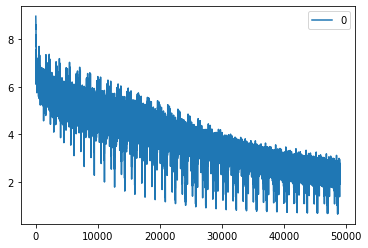

In [ ]:
import pandas as pd

loss_plot = pd.DataFrame(model.average_loss)
loss_plot.plot()

# **Predict Function**

In [ ]:
def predict(model, first_words ,story_len ,top_k):
    '''
    param model: trained model
    param first_words: a string of 5 (n_feature) words to begin the story
    param story_len: an integer symbolizing the number of words you'd like the story to have
    param top_k: the number of top probabilities per word that the network will randomly select from
    '''
    feature = (first_words.lower()).split(" ")
    for i in feature:
        story.append(i)
    for i in range(story_len):
        feature_idx = torch.tensor([word_to_idx[word] for word in feature], dtype=torch.long)
        feature_idx = feature_idx.to(device)
        with torch.no_grad():
            output = model.double().forward(feature_idx)
        ps = torch.exp(output)
        topk_combined = ps.topk(top_k, sorted=True)
        #top kk probabilities
        topk_ps = topk_combined[0][0]
        #top kk classes
        topk_class = topk_combined[1][0]
        topk_class = [idx_to_word[int(i)] for i in topk_class]
        next_word = random.choice(topk_class)
        feature = feature[1:]
        feature.append(next_word)
        story.append(next_word)
    return story

# **Predict**

In [ ]:
import random
word_to_idx = model.word_to_index
idx_to_word = model.index_to_word
first_words = input('Type the first {} words to start the story:\nexample: A lovely day at the\n'.format(batch_size))

top_k = 3
story_len = 50
story = []
device = 'cuda:0'

#Predicting and Handling User-Input Errors
try:      
    prediction = predict(model, first_words, story_len, top_k)
except KeyError as error:
    print('Oops, looks like you\'ve selected a word that the network does not understand yet: ', error)
    if story[0] != "":
        story = story[len(first_words):]
    first_words = input('please select a different word:\nexample: A lovely day at the\n')
    prediction = predict(model, first_words, story_len, top_k)
except KeyError and RuntimeError:
    if story[0] != "":
        story = story[len(first_words):]
    first_words = input('Oops, looks like you\'ve typed {} words instead of {}!\n\nType the first 5 words to start the story:\nexample: A lovely day at the\n'.format(len(first_words.split(" ")), n_features))
    prediction = predict(model, first_words, story_len, top_k)

print('-----------------------------------------------------\n The STORY \n-----------------------------------------------------')
print(" ".join(story))

Type the first 5 words to start the story:
example: A lovely day at the
there was a lovely princess
-----------------------------------------------------
 The STORY 
-----------------------------------------------------
there was a lovely princess for her mother coming to their children and they found was at an end his turn beautiful that he was now and when they had sung my of his money court like of that the bear was gone from and gathered in the cinders so come with me and had
